In [108]:
import pandas as pd
import numpy as np
import math
import random
%matplotlib inline
import random
from matplotlib import pyplot
import os

In [109]:
class ExNode:
    def __init__(self,size):
        self.size=size
        
class InNode:
    def __init__(self,left,right,splitAtt,splitVal):
        self.left=left
        self.right=right
        self.splitAtt=splitAtt
        self.splitVal=splitVal

In [110]:
def iForest(X,noOfTrees,sampleSize):
    forest=[]
    hlim=math.ceil(math.log(sampleSize,2))
    for i in range(noOfTrees):
        X_train=X.sample(sampleSize)
        forest.append(iTree(X_train,0,hlim))
    return forest

In [111]:
def iTree(X,currHeight,hlim):
    if currHeight>=hlim or len(X)<=1:
        return ExNode(len(X))
    else:
        Q=X.columns
        q=random.choice(Q)
        p=random.choice(X[q].unique())
        X_l=X[X[q]<p]
        X_r=X[X[q]>=p]
        return InNode(iTree(X_l,currHeight+1,hlim),iTree(X_r,currHeight+1,hlim),q,p)

In [112]:
def pathLength(x,Tree,currHeight):
    if isinstance(Tree,ExNode):
        return currHeight
    a=Tree.splitAtt
    if x[a]<Tree.splitVal:
        return pathLength(x,Tree.left,currHeight+1)
    else:
        return pathLength(x,Tree.right,currHeight+1)

In [113]:
df = pd.read_csv("creditcard.csv")
y_true = df['Class']
df_data = df.drop('Class', axis=1)

In [114]:
sampleSize=10000
ifor=iForest(df_data.sample(100000),10,sampleSize) ##Forest of 10 trees

In [115]:
posLenLst=[]
negLenLst=[]

for sim in range(1000):
    ind=random.choice(df_data[y_true==1].index)
    for tree in ifor:
        posLenLst.append(pathLength(df_data.iloc[ind],tree,0))
        
    ind=random.choice(df_data[y_true==0].index)
    for tree in ifor:
        negLenLst.append(pathLength(df_data.iloc[ind],tree,0))

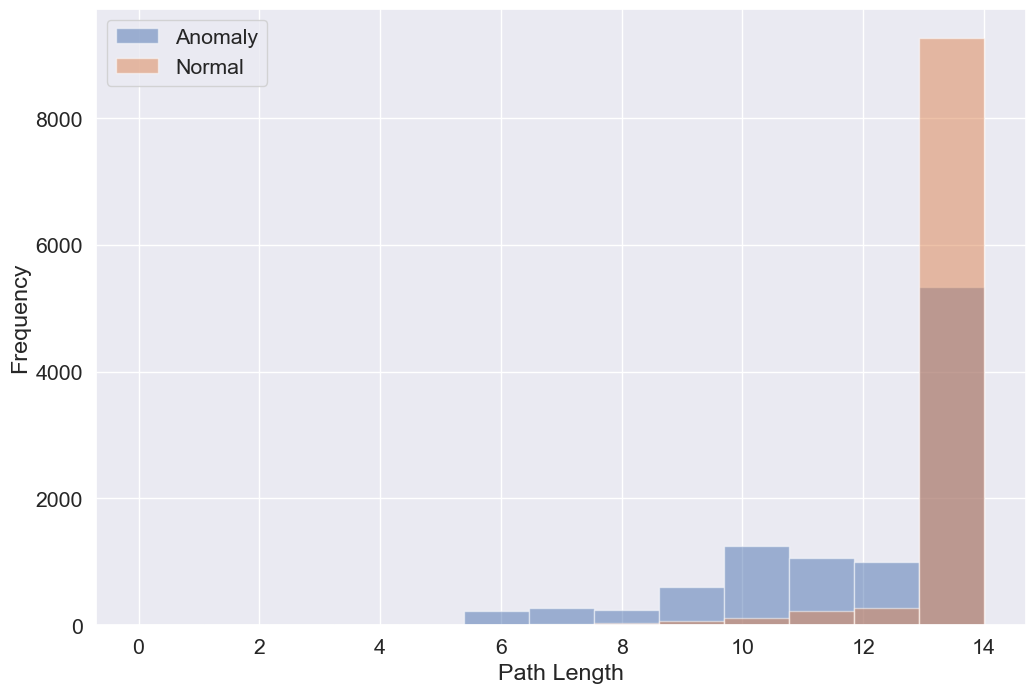

In [116]:
bins = np.linspace(0,math.ceil(math.log(sampleSize,2)), math.ceil(math.log(sampleSize,2)))

pyplot.figure(figsize=(12,8))
pyplot.hist(posLenLst, bins, alpha=0.5, label='Anomaly')
pyplot.hist(negLenLst, bins, alpha=0.5, label='Normal')
pyplot.xlabel('Path Length')
pyplot.ylabel('Frequency')
pyplot.legend(loc='upper left')

In [117]:
from sklearn.manifold import TSNE

In [118]:
df_plt=df[df['Class']==0].sample(1000)
df_plt_pos=df[df['Class']==1].sample(20)
df_plt=pd.concat([df_plt,df_plt_pos])
y_plt=df_plt['Class']
X_plt=df_plt.drop('Class', axis = 1)

In [119]:
X_embedded = TSNE(n_components=2).fit_transform(X_plt)

/var/folders/9b/14tvh8y11v34cytshtrh1nz80000gn/T/ipykernel_31870/1498020118.py:2: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  pyplot.scatter(X_embedded[:,0], X_embedded[:,1], c=y_plt, cmap=pyplot.cm.get_cmap("Paired", 2))


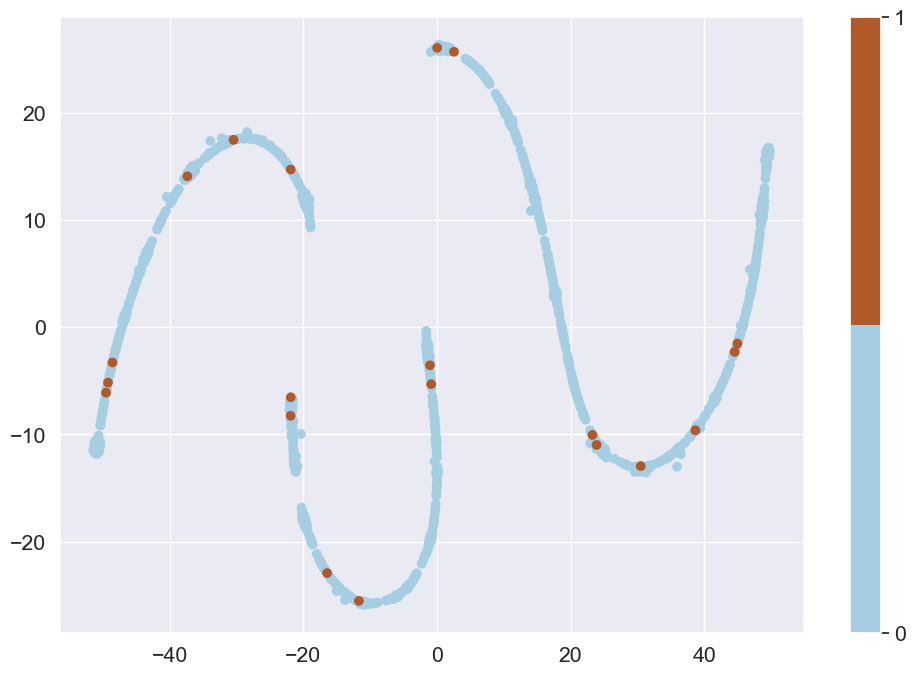

In [120]:
pyplot.figure(figsize=(12,8))
pyplot.scatter(X_embedded[:,0], X_embedded[:,1], c=y_plt, cmap=pyplot.cm.get_cmap("Paired", 2))
pyplot.colorbar(ticks=range(2))

In [121]:
from sklearn.ensemble import IsolationForest
from sklearn.svm import OneClassSVM
from sklearn.neighbors import LocalOutlierFactor
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split

In [122]:
X_train, X_test, y_train, y_test = train_test_split(df_data, y_true, test_size=0.3, random_state=42)

In [123]:
def preprocess(df_data):
    for col in df_data:
        df_data[col]=(df_data[col]-np.min(df_data[col]))/(np.max(df_data[col])-np.min(df_data[col]))
    return

In [124]:
def train(X,clf,ensembleSize=5,sampleSize=10000):
    mdlLst=[]
    for n in range(ensembleSize):
        X=df_data.sample(sampleSize)
        clf.fit(X)
        mdlLst.append(clf)
    return mdlLst

In [125]:
def predict(X,mdlLst):
    y_pred=np.zeros(X.shape[0])
    for clf in mdlLst:
        y_pred=np.add(y_pred,clf.decision_function(X).reshape(X.shape[0],))
    y_pred=(y_pred*1.0)/len(mdlLst)
    return y_pred

In [126]:
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix,f1_score

In [127]:
from sklearn.ensemble import IsolationForest

alg = IsolationForest(
    n_estimators=100,
    max_samples='auto',
    contamination=0.01,
    max_features=1.0,
    bootstrap=False,
    n_jobs=-1,
    random_state=42,
    verbose=0
)

In [128]:
%%timeit
if_mdlLst=train(X_train,alg)

473 ms ± 9.16 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [129]:
if_mdlLst=train(X_train,alg)

In [130]:
if_y_pred=predict(X_test,if_mdlLst)
if_y_pred=1-if_y_pred

#Creating class labels based on decision function
if_y_pred_class=if_y_pred.copy()
if_y_pred_class[if_y_pred>=np.percentile(if_y_pred,95)]=1
if_y_pred_class[if_y_pred<np.percentile(if_y_pred,95)]=0

In [131]:
roc_auc_score(y_test, if_y_pred_class)

np.float64(0.9057879792638215)

In [132]:
f1_score(y_test, if_y_pred_class)

np.float64(0.053073259242458606)

In [133]:
if_cm=confusion_matrix(y_test, if_y_pred_class)

<Axes: >

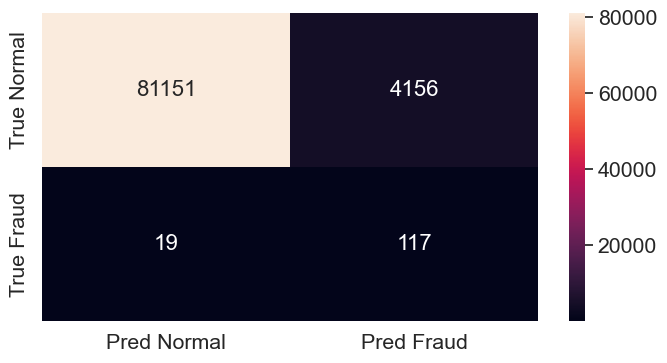

In [134]:
import seaborn as sn
     
df_cm = pd.DataFrame(if_cm,
                  ['True Normal','True Fraud'],['Pred Normal','Pred Fraud'])
pyplot.figure(figsize = (8,4))
sn.set(font_scale=1.4)#for label size
sn.heatmap(df_cm, annot=True,annot_kws={"size": 16},fmt='g')

AUC-PR: 0.30


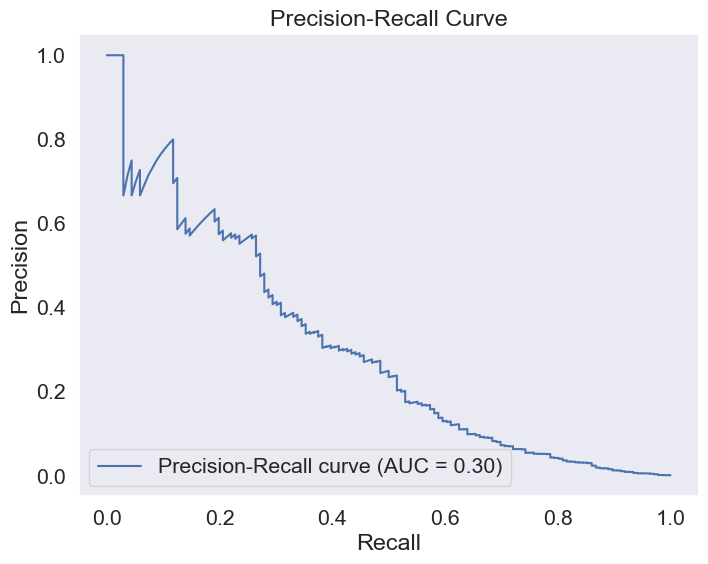

In [137]:
from sklearn.metrics import precision_recall_curve, auc
import matplotlib.pyplot as plt

scores = -alg.decision_function(X_test)
precision, recall, thresholds = precision_recall_curve(y_test, scores)
auc_pr = auc(recall, precision)
print(f"AUC-PR: {auc_pr:.2f}")

plt.figure(figsize=(8, 6))
plt.plot(recall, precision, label=f'Precision-Recall curve (AUC = {auc_pr:.2f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc='lower left')
plt.grid()
plt.show()